In [1]:
import torch
from torch.nn import Parameter
from gpytorch.distributions import MultitaskMultivariateNormal, MultivariateNormal

from alfi.models import OrdinaryLFM, generate_multioutput_rbf_gp
from alfi.trainers import VariationalTrainer
from alfi.utilities.torch import softplus
from alfi.configuration import VariationalConfiguration
from alfi.datasets import ToyTranscriptomicGenerator
from alfi.plot import Plotter1d

from matplotlib import pyplot as plt

import numpy as np


In [2]:
    # def predict_f(self, t_predict):
    #     # Sample from the latent distribution
    #     q_f = super().predict_f(t_predict)
    #     f = q_f.sample(torch.Size([500])).permute(0, 2, 1)  # (S, I, T)
    #     print(f.shape)
    #     # This is a hack to wrap the latent function with the nonlinearity. Note we use the same variance.
    #     f = torch.mean(self.G(f), dim=0)[0].unsqueeze(0)
    #     print(f.shape, q_f.mean.shape, q_f.scale_tril.shape)
    #     batch_mvn = MultivariateNormal(f, q_f.covariance_matrix.unsqueeze(0))
    #     print(batch_mvn)
    #
    #     return MultitaskMultivariateNormal.from_batch_mvn(batch_mvn, task_dim=0)

In [19]:
print(torch.finfo(torch.float32).tiny)
config = VariationalConfiguration(
    num_samples=70,
    initial_conditions=False # TODO
)

num_latents = 3
num_outputs = 30
dataset = ToyTranscriptomicGenerator(
    num_outputs, num_latents, softplus=True)
dataset.generate_single()#basal_rate, sensitivity, decay_rate, lengthscale=lengthscale)
print(dataset.t_observed)
# plt.plot(dataset[])

1.1754943508222875e-38
tensor([0.0000, 1.0000, 2.0000, 3.0000, 4.0000, 5.0000, 6.0000, 7.0000, 8.0000,
        9.0000])


Now let's try to train a model to get the same results

In [21]:
class TranscriptionLFM(OrdinaryLFM):
    def __init__(self, num_outputs, gp_model, config: VariationalConfiguration):
        super().__init__(num_outputs, gp_model, config)
        num_latents = gp_model.variational_strategy.num_tasks
        self.decay_rate = Parameter(0.1 + torch.rand(torch.Size([self.num_outputs, 1]), dtype=torch.float32))
        self.basal_rate = Parameter(0.1 + torch.rand(torch.Size([self.num_outputs, 1]), dtype=torch.float32))
        # self.sensitivity = Parameter(0.1 + torch.rand(torch.Size([self.num_outputs, 1]), dtype=torch.float32))
        self.weight = Parameter(0.5 * torch.randn(torch.Size([self.num_outputs, num_latents]), dtype=torch.float32))
        self.weight_bias = Parameter(torch.randn(torch.Size([self.num_outputs, 1]), dtype=torch.float32))

    def initial_state(self):
        return self.basal_rate / self.decay_rate

    def odefunc(self, t, h):
        """h is of shape (num_samples, num_outputs, 1)"""
        self.nfe += 1
        # if (self.nfe % 100) == 0:
        #     print(t)
        # print(t, self.t_index)
        # print(self.f.shape)
        decay = self.decay_rate * h

        f = self.f[:, :, self.t_index].unsqueeze(2)
        # print(f.shape, self.sensitivity.shape)
        h = self.basal_rate + f - decay
        if t > self.last_t:
            self.t_index += 1
        self.last_t = t
        return h

    def mix(self, f):
        # return f.repeat(1, 10, 1)
        f = softplus(f)
        interactions = torch.matmul(self.weight, torch.log(f+1e-100)) + self.weight_bias
        f = torch.sigmoid(interactions) # TF Activation Function (sigmoid)
        return f

In [30]:
num_inducing = 12  # (I x m x 1)
inducing_points = torch.linspace(0, 12, num_inducing).repeat(num_latents, 1).view(num_latents, num_inducing, 1)
t_predict = torch.linspace(0, 13, 80, dtype=torch.float32)

gp_model = generate_multioutput_rbf_gp(num_latents, inducing_points,
                                       initial_lengthscale=1,
                                       gp_kwargs=dict(natural=False))
lfm = TranscriptionLFM(num_outputs, gp_model, config)
plotter = Plotter1d(lfm, np.arange(num_outputs))

optimizer = torch.optim.Adam(lfm.parameters(), lr=0.01)

trainer = VariationalTrainer(lfm, [optimizer], dataset)

In [54]:
times = trainer.train(100, report_interval=10, step_size=5e-1)

C:\Users\Jacob\miniconda3\envs\wishart\lib\site-packages\gpytorch\distributions\multivariate_normal.py:230: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  NumericalWarning,


Epoch 1001/1100 - Loss: -82.46 (-84.33 1.87) kernel: [1.5689356 1.7532138 1.2205318]
Epoch 1011/1100 - Loss: -83.12 (-85.00 1.88) kernel: [1.5706058 1.7531269 1.2204925]
Epoch 1021/1100 - Loss: -83.18 (-85.06 1.88) kernel: [1.5693965 1.7527    1.2198731]
Epoch 1031/1100 - Loss: -83.47 (-85.36 1.89) kernel: [1.571539  1.7524838 1.2200401]
Epoch 1041/1100 - Loss: -83.99 (-85.90 1.91) kernel: [1.5717928 1.7539551 1.2210684]
Epoch 1051/1100 - Loss: -84.22 (-86.13 1.91) kernel: [1.5707824 1.7538483 1.2202107]
Epoch 1061/1100 - Loss: -84.64 (-86.55 1.91) kernel: [1.5726596 1.7529309 1.2205873]
Epoch 1071/1100 - Loss: -85.09 (-87.01 1.92) kernel: [1.5756844 1.7545503 1.2216972]
Epoch 1081/1100 - Loss: -85.13 (-87.06 1.92) kernel: [1.5742133 1.7510046 1.2214695]
Epoch 1091/1100 - Loss: -85.06 (-86.99 1.93) kernel: [1.5766728 1.7536612 1.2214465]


torch.Size([1, 3, 10])

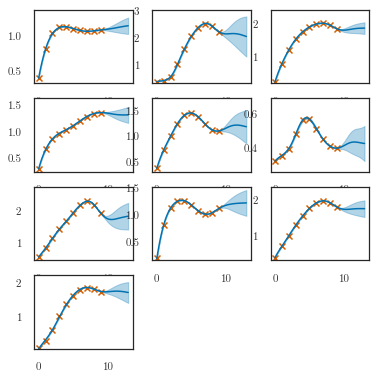

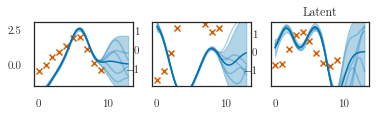

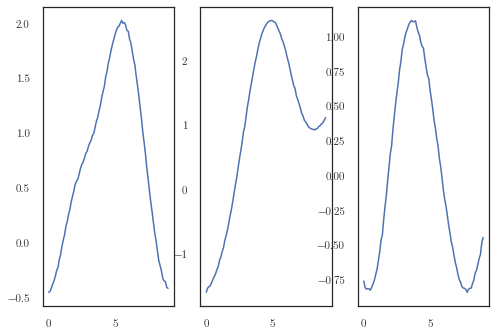

In [55]:
lfm.eval()
# labels = ['Basal rates', 'Sensitivities', 'Decay rates']
# keys = ['raw_basal', 'raw_sensitivity', 'raw_decay']
# constraints = [lfm.positivity, lfm.positivity, lfm.positivity]
# kinetics = list()
# for i, key in enumerate(keys):
#     kinetics.append(
#         constraints[i].transform(trainer.parameter_trace[key][-1].squeeze()).numpy())
#
# print(kinetics[0].shape)
# plotter.plot_double_bar(kinetics, labels, figsize=(10, 3), ground_truths=hafner_ground_truth())
q_m = lfm.predict_m(t_predict, step_size=1e-1)
q_f = lfm.predict_f(t_predict)

plotter.plot_gp(q_m, t_predict, replicate=0,
                t_scatter=dataset.t_observed,
                y_scatter=dataset.m_observed, num_samples=0)
plotter.plot_gp(q_f, t_predict,
                t_scatter=dataset.t_observed,
                y_scatter=dataset.f_observed, num_samples=5)
plt.title('Latent')
fig, axes = plt.subplots(ncols=3)
for i in range(3):
    axes[i].plot(dataset.t_observed_highres, dataset.f_observed_highres[0, i])
dataset.f_observed.shape

In [39]:
gp_model.covar_module.lengthscale

tensor([[[1.3871]],

        [[1.6633]],

        [[0.7071]]], grad_fn=<SoftplusBackward>)